# 项目：指导四轴飞行器学会飞行

设计一个能够使四轴飞行器飞行的智能体，然后使用你选择的强化学习算法训练它！

请尝试运用你在这一单元中学到的知识，看看哪个方法效果最好，当然你也可以自己想出创新型方法并测试它们。
## 说明

请查看目录下的文件，以更好地了解项目结构。 

- `task.py`：在本文件中定义你的任务（环境）。
- `agents/`：本文件夹中包含强化学习智能体。
    - `policy_search.py`：我们为你提供了一个智能体模板。
    - `agent.py`：在本文件中开发你的智能体。
- `physics_sim.py`：本文件中包含四轴飞行器模拟器。**请勿修改本文件**。

在本项目中，你需要在 `task.py` 中定义你的任务。尽管我们为你提供了一个任务示例，来帮助你开始项目，但你也可以随意更改这个文件。在这个 notebook 中，你还将学习更多有关修改这个文件的知识。

你还需要在 `agent.py` 中设计一个强化学习智能体，来完成你选择的任务。

我们也鼓励你创建其他文件，来帮助你整理代码。比如，你也许可以通过定义一个 `model.py` 文件来定义其他你需要的神经网络结构。

## 控制四轴飞行器

在下方的代码中，我们提供了一个智能体示例，来示范如何使用模拟器来控制四轴飞行器。这个智能体比你在 notebook 中需要测试的智能体（在 `agents/policy_search.py` 中）更加简单！

这个智能体通过设置飞行器四个轴上的转速来控制飞行器。`Basic_Agent` 类中提供的智能体将会随机为四个轴指定动作。这四个速度将通过 `act` 方法以四个浮点数列表的形式返回。


在本项目中，你将在 `agents/agent.py` 中实现的智能体会以更加智能的方法进行指定的动作。

### plot

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_run(results, standalone=True):
    if standalone:
        plt.subplots(figsize=(15, 15))
    
    #查看四轴飞行器的位置变化
    plt.subplot(3, 3, 1)
    plt.title('Position')
    plt.plot(results['time'], results['x'], label='x')
    plt.plot(results['time'], results['y'], label='y')
    plt.plot(results['time'], results['z'], label='z')
    plt.xlabel('time, seconds')
    plt.ylabel('Position')
    plt.grid(True)
    if standalone:
        plt.legend()

    #四轴飞行器的速度
    plt.subplot(3, 3, 2)
    plt.title('Velocity')
    plt.plot(results['time'], results['x_velocity'], label='x_hat')
    plt.plot(results['time'], results['y_velocity'], label='y_hat')
    plt.plot(results['time'], results['z_velocity'], label='z_hat')
    plt.xlabel('time, seconds')
    plt.ylabel('Velocity')
    plt.grid(True)
    if standalone:
        plt.legend()
    
    #绘制欧拉角 (Euler angles)（四轴飞行器围绕 x，y 和 z 轴的旋转）的图表
    plt.subplot(3, 3, 3)
    plt.title('Orientation')
    plt.plot(results['time'], results['phi'], label='phi')
    plt.plot(results['time'], results['theta'], label='theta')
    plt.plot(results['time'], results['psi'], label='psi')
    plt.xlabel('time, seconds')
    plt.grid(True)
    if standalone:
        plt.legend()
    
    #绘制每个欧拉角的速度（每秒的弧度）图
    plt.subplot(3, 3, 4)
    plt.title('Angular Velocity')
    plt.plot(results['time'], results['phi_velocity'], label='phi')
    plt.plot(results['time'], results['theta_velocity'], label='theta')
    plt.plot(results['time'], results['psi_velocity'], label='psi')
    plt.xlabel('time, seconds')
    plt.grid(True)
    if standalone:
        plt.legend()

    #最后，你可以使用下方代码来输出智能体选择的动作。
    plt.subplot(3, 3, 5)
    plt.title('Rotor Speed')
    plt.plot(results['time'], results['rotor_speed1'], label='Rotor 1')
    plt.plot(results['time'], results['rotor_speed2'], label='Rotor 2')
    plt.plot(results['time'], results['rotor_speed3'], label='Rotor 3')
    plt.plot(results['time'], results['rotor_speed4'], label='Rotor 4')
    plt.xlabel('time, seconds')
    plt.ylabel('Rotor Speed, revolutions / second')
    plt.grid(True)
    if standalone:
        plt.legend()

    if standalone:
        plt.tight_layout()
        plt.show()

[autoreload of task failed: Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/opt/conda/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 368, in superreload
    module = reload(module)
  File "/opt/conda/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/opt/conda/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 674, in exec_module
  File "<frozen importlib._bootstrap_external>", line 781, in get_code
  File "<frozen importlib._bootstrap_external>", line 741, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/workspace/task.py", line 43
    if self.sim.pose[:3] = self.target_pos:


In [12]:
from mpl_toolkits.mplot3d.axes3d import Axes3D


def plot_point3d(ax, x, y, z, **kwargs):
    ax.scatter([x], [y], [z], **kwargs)
    ax.text(x, y, z, "({:.1f}, {:.1f}, {:.1f})".format(x, y, z))


def show_flight_path(results, target=None):
    results = np.array(results)
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')

    ax.plot3D(results[:, 0], results[:, 1], results[:, 2], 'gray')
    
    if target is not None:
        plot_point3d(ax, *target[0:3], c='y', marker='x', s=100, label='target')
        
    plot_point3d(ax, *results[0, 0:3], c='g', marker='o', s=50, label='start')
    plot_point3d(ax, *results[-1, 0:3], c='r', marker='o', s=50, label='end')
    
    ax.legend()

### random Agent

In [13]:
import random

class Basic_Agent():
    def __init__(self, task):
        self.task = task
    
    def act(self):
        new_thrust = random.gauss(450., 25.)
        return [new_thrust + random.gauss(0., 1.) for x in range(4)]

运行下方代码，让智能体指定动作来控制四轴飞行器。

请随意更改我们提供的 `runtime`，`init_pose`，`init_velocities` 和 `init_angle_velocities` 值来更改四轴飞行器的初始条件。

下方的 `labels` 列表为模拟数据的注释。所有的信息都储存在 `data.txt` 文档中，并保存在 `results` 目录下。

In [14]:
%load_ext autoreload
%autoreload 2

import csv
import numpy as np
from task import Task

# Modify the values below to give the quadcopter a different starting position.
runtime = 5.                                     # time limit of the episode
init_pose = np.array([0., 0., 10., 0., 0., 0.])  # initial pose
init_velocities = np.array([0., 0., 0.])         # initial velocities
init_angle_velocities = np.array([0., 0., 0.])   # initial angle velocities
file_output = 'data.txt'                         # file name for saved results

# Setup
task = Task(init_pose, init_velocities, init_angle_velocities, runtime)
agent = Basic_Agent(task)
done = False
labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4']
results = {x : [] for x in labels}

# Run the simulation, and save the results.
with open(file_output, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(labels)
    while True:
        rotor_speeds = agent.act()
        _, _, done = task.step(rotor_speeds)
        to_write = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(rotor_speeds)
        for ii in range(len(labels)):
            results[labels[ii]].append(to_write[ii])
        writer.writerow(to_write)
        if done:
            break

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


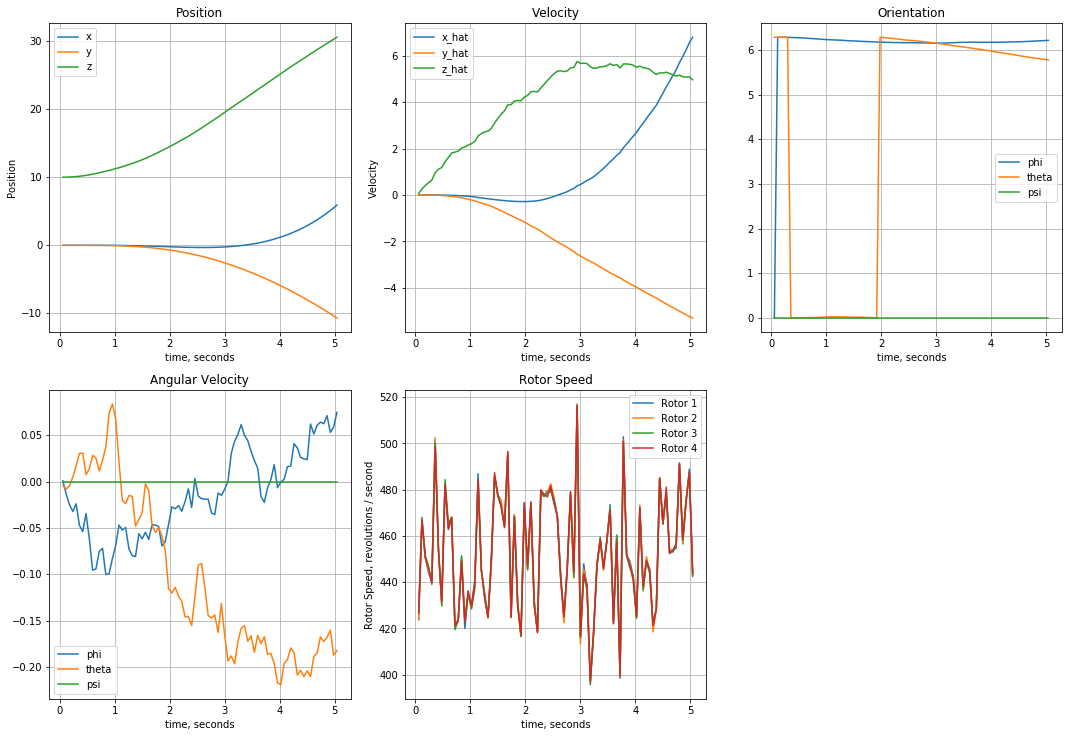

In [15]:
plot_run(results)

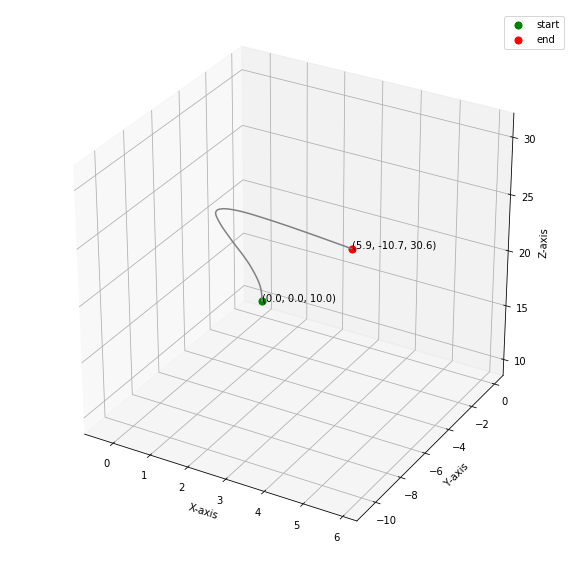

In [16]:
path = [[results['x'][i], results['y'][i], results['z'][i]] for i in range(len(results['x']))]
show_flight_path(path, target=None)

在指定任务之前，你需要在模拟器中衍生环境状态。运行下方代码来在模拟结束时输出以下变量值：

- `task.sim.pose`：四周飞行器在 ($x,y,z$) 坐标系中的位置和欧拉角。
- `task.sim.v`：四轴飞行器在 ($x,y,z$) 坐标系中的速度。
- `task.sim.angular_v`：三个欧拉角的弧度/每秒。

In [17]:
# the pose, velocity, and angular velocity of the quadcopter at the end of the episode
print(task.sim.pose)
print(task.sim.v)
print(task.sim.angular_v)

[  5.89991582 -10.68352669  30.57547544   6.21195388   5.7737278    0.        ]
[ 6.79458573 -5.2950648   4.9584437 ]
[ 0.07489462 -0.18219756  0.        ]


在 `task.py` 中的任务示例中，我们使用了四轴飞行器六个维度的动作来构建每个时间步的环境状态。然而，你也可以按照自己的意愿更改任务，你可以添加速度信息来扩大状态向量，也可以使用任何动作、速度和角速度的组合，并构造适用于你的任务的环境状态。

## 任务

在 `task.py` 中，我们为你提供了一个任务示例。请在新窗口中打开这个文件。

使用 `__init__()` 方法来初始化指定本任务所需的几个变量。

- 模拟器作为 `PhysicsSim` 类（来自 `physics_sim.py` 文件）的示例进行初始化。
- 受到 DDPG 论文中研究方法的启发，我们使用了重复调用动作的方法。对于智能体的每一个时间步，我们将利用 `action_repeats` 时间步来进行模拟。如果你并不熟悉这种方法，可以阅读 [DDPG 论文](https://arxiv.org/abs/1509.02971)的结论部分。
- 我们设置了状态向量中每个分量的数值。在任务示例中，我们只设置了六个维度的动作信息。为了设定向量大小（`state_size`），我们必须考虑重复的动作。
- 任务环境通常是一个四维动作空间，每个轴有一个输入（`action_size=4`）。你可以设置每个输入的最小值（`action_low`）和最大值（`action_high`）。
- 我们在文件中提供的任务示例将使智能体达到目标位置。我们将目标位置设置为一个变量。

`reset()` 方法将重置模拟器。每当阶段结束时，智能体都将调用此方法。你可以查看下方代码中的例子。

`step()` 方法是最重要的一个方法。它将接收智能体选择的动作 `rotor_speeds`，并准备好下一个状态，同时返回给智能体。接着，你将通过 `get_reward()` 计算奖励值。当超过规定时间，或是四轴飞行器到达模拟器边缘时，这一阶段将视作结束。

接下来，你将学习如何测试这个任务中智能体的性能。

## 智能体

`agents/policy_search.py` 文件中提供的智能体示例使用了非常简单的线性策略，将动作向量视作状态向量和矩阵权重的点积直接进行计算。接着，它通过添加一些高斯噪声来随机干扰参数，以产生不同的策略。根据每个阶段获得的平均奖励值（`score`），它将记录迄今为止发现的最佳参数集以及分数的变化状态，并据此调整比例因子来扩大或减少噪音。

请运行下方代码来查看任务示例中智能体的性能。

In [18]:
import sys
import pandas as p

In [19]:
from agents.policy_search import PolicySearch_Agent
from task import Task

labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4']
results = {x : [] for x in labels}

num_episodes = 1
target_pos = np.array([0., 0., 10.])
task = Task(target_pos=target_pos)
agent = PolicySearch_Agent(task) 

for i_episode in range(1, num_episodes+1):
    state = agent.reset_episode() # start a new episode
    while True:
        action = agent.act(state) 
        next_state, reward, done = task.step(action)
        if i_episode == num_episodes:
            to_write = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(action)
            for ii in range(len(labels)):
                results[labels[ii]].append(to_write[ii])
        agent.step(reward, done)
        state = next_state
        if done:
            print("\rEpisode = {:4d}, score = {:7.3f} (best = {:7.3f}), noise_scale = {}".format(
                i_episode, agent.score, agent.best_score, agent.noise_scale), end="")  # [debug]
            break
    sys.stdout.flush()

Episode =    1, score =  -1.364 (best =  -1.364), noise_scale = 0.05

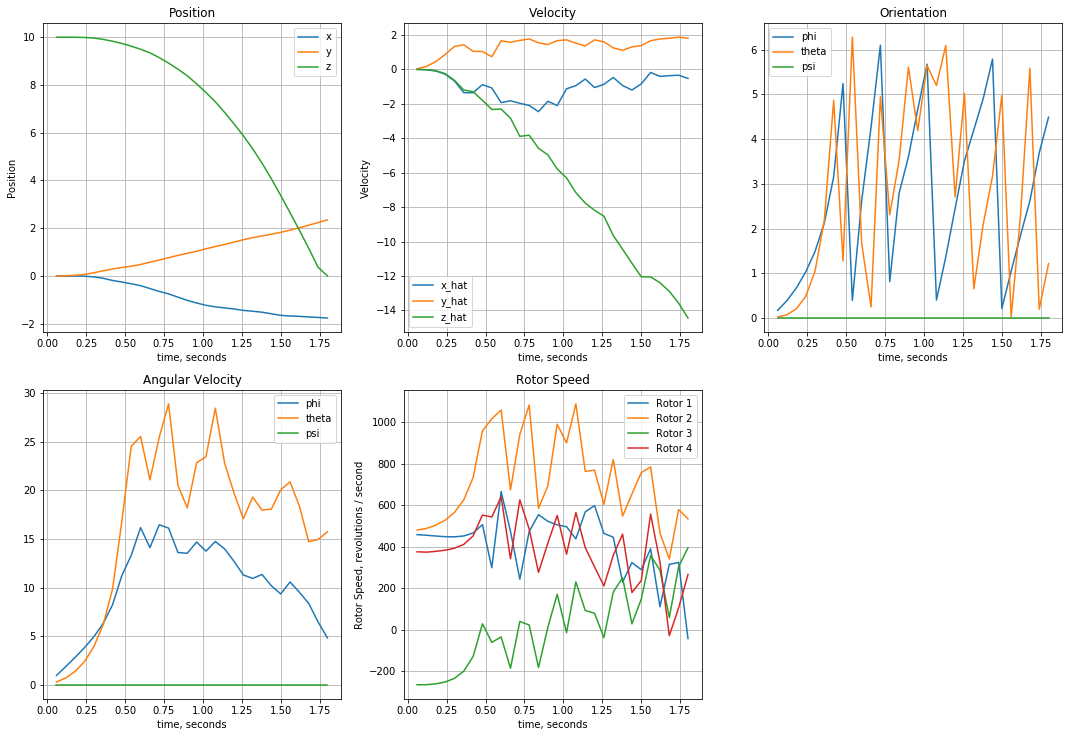

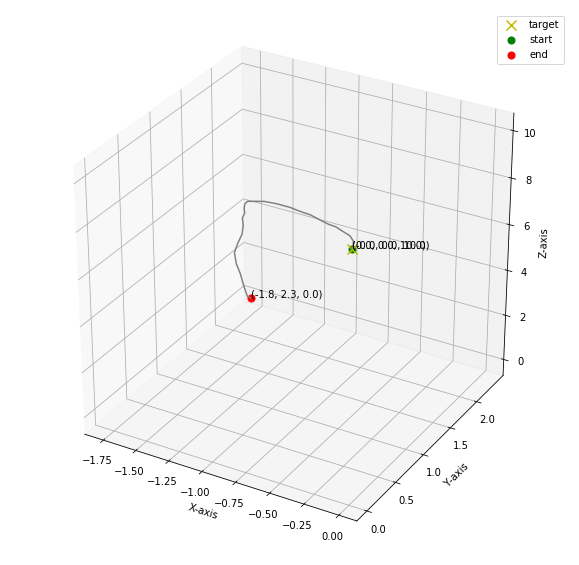

In [20]:
plot_run(results)

path = [[results['x'][i], results['y'][i], results['z'][i]] for i in range(len(results['x']))]
show_flight_path(path, target=target_pos)

这个智能体的性能想必十分糟糕！现在轮到你出场了！

## 定义任务，设计并训练你的智能体！

修改 `task.py` 文件来指定你所选择的任务。如果你不确定选择什么任务，你可以教你的四轴飞行器起飞、盘旋、着陆或是达到指定位置。


在指定任务后，使用 `agents/policy_search.py` 中的智能体示例作为模板，来在 `agents/agent.py` 中定义你自己的智能体。你可以随意从智能体示例中借用你需要的元素，包括如何模块化你的代码（使用 `act()`，`learn()` 和 `reset_episode_vars()` 等辅助方法）。

请注意，你指定的第一个智能体和任务**极有可能**无法顺利进行学习。你将需要改进不同的超参数和奖励函数，直到你能够获得不错的结果。

在开发智能体的时候，你还需要关注它的性能。参考下方代码，建立一个机制来存储每个阶段的总奖励值。如果阶段奖励值在逐渐上升，说明你的智能体正在学习。

In [25]:
## TODO: Train your agent here.
from task import Task
from agents.agent1 import agent1
import numpy as np
labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4']
results = {x : [] for x in labels}
init_pose = np.array([0., 0., 1., 0., 0., 0.])  # initial pose
init_velocities = np.array([0., 0., 0.])         # initial velocities
init_angle_velocities = np.array([0., 0., 0.])   # initial angle velocities

num_episodes = 1500
target_pos = np.array([0., 0., 10.])
task = Task(init_pose = init_pose,init_velocities = init_velocities,init_angle_velocities = init_angle_velocities,target_pos=target_pos)

agent = agent1(task) 

In [26]:
Episode = list()
Total_reward = list()
step = 0
for i_episode in range(1, num_episodes+1):
    state = agent.reset_episode() # start a new episode
    total_reward = 0 
    while True:
        action = agent.act(state)
        next_state, reward, done = task.step(action)
        agent.step(action,reward,next_state,done)
        total_reward += reward
        state = next_state     
        if done == True:
            print('Episode: {}'.format(i_episode),
            'Total reward: {}'.format(total_reward))
            Episode.append(i_episode)
            Total_reward.append(total_reward)
            break 
    sys.stdout.flush()


Episode: 1 Total reward: 17.281578222753122
Episode: 2 Total reward: 17.28124331017341
Episode: 3 Total reward: 17.281054350372255
Episode: 4 Total reward: 17.28181145605018
Episode: 5 Total reward: 19.415712303598607
Episode: 6 Total reward: 27.29670202483204
Episode: 7 Total reward: 23.55380140929208
Episode: 8 Total reward: 17.0731005598307
Episode: 9 Total reward: 23.261693439805782
Episode: 10 Total reward: 16.91290554686985
Episode: 11 Total reward: 22.91030576386867
Episode: 12 Total reward: 18.76980744083603
Episode: 13 Total reward: -391.2651389077914
Episode: 14 Total reward: 28.08770726972364
Episode: 15 Total reward: 28.167863725237083
Episode: 16 Total reward: 28.202614826554406
Episode: 17 Total reward: 28.13000598945294
Episode: 18 Total reward: 28.207995949935206
Episode: 19 Total reward: 28.201015534796888
Episode: 20 Total reward: 28.174239693856077
Episode: 21 Total reward: 28.1670780320643
Episode: 22 Total reward: 28.193355551553545
Episode: 23 Total reward: 28.178

Episode: 184 Total reward: 27.863549830733085
Episode: 185 Total reward: 27.8598534686841
Episode: 186 Total reward: 27.853681762649263
Episode: 187 Total reward: 27.862341016690223
Episode: 188 Total reward: 27.8603786606418
Episode: 189 Total reward: 27.852652126572753
Episode: 190 Total reward: 27.846866855475113
Episode: 191 Total reward: 27.841493640039303
Episode: 192 Total reward: 27.840495310851377
Episode: 193 Total reward: 27.846517632123117
Episode: 194 Total reward: 27.853317831496724
Episode: 195 Total reward: 27.844860829389688
Episode: 196 Total reward: 27.835928652476174
Episode: 197 Total reward: 27.827057089768914
Episode: 198 Total reward: 27.849965929235978
Episode: 199 Total reward: 27.833743657853276
Episode: 200 Total reward: 27.835553383523795
Episode: 201 Total reward: 27.83989683191819
Episode: 202 Total reward: 27.83264310793814
Episode: 203 Total reward: 27.84826937667116
Episode: 204 Total reward: 27.833244450023695
Episode: 205 Total reward: 27.83468134156

Episode: 364 Total reward: 27.824400394321
Episode: 365 Total reward: 27.82525391475725
Episode: 366 Total reward: 27.823988028150062
Episode: 367 Total reward: 27.825350420105327
Episode: 368 Total reward: 27.82528197094273
Episode: 369 Total reward: 27.833306315178493
Episode: 370 Total reward: 27.83258263867409
Episode: 371 Total reward: 27.82528642672814
Episode: 372 Total reward: 27.826807916613074
Episode: 373 Total reward: 27.826780487058574
Episode: 374 Total reward: 27.82330221067747
Episode: 375 Total reward: 27.801715493011496
Episode: 376 Total reward: 27.832052500283556
Episode: 377 Total reward: 27.839503260799262
Episode: 378 Total reward: 27.832390530001906
Episode: 379 Total reward: 27.837339252625547
Episode: 380 Total reward: 27.83120165563941
Episode: 381 Total reward: 27.838244650719513
Episode: 382 Total reward: 27.826092948142158
Episode: 383 Total reward: 27.837371742344544
Episode: 384 Total reward: 27.828984074575885
Episode: 385 Total reward: 27.8307547786667

Episode: 546 Total reward: 36.247097093366854
Episode: 547 Total reward: 39.66400284180643
Episode: 548 Total reward: 36.25259224552163
Episode: 549 Total reward: 37.99301134890068
Episode: 550 Total reward: 39.665138527450424
Episode: 551 Total reward: 38.00582229570954
Episode: 552 Total reward: 36.25786459990279
Episode: 553 Total reward: 36.263027917415
Episode: 554 Total reward: 37.985930988404775
Episode: 555 Total reward: 38.00229657200649
Episode: 556 Total reward: 36.235690865190556
Episode: 557 Total reward: 36.25972425540138
Episode: 558 Total reward: 37.970084346887475
Episode: 559 Total reward: 36.26929705865553
Episode: 560 Total reward: 36.253400583297655
Episode: 561 Total reward: 37.983257895978674
Episode: 562 Total reward: 37.97852285209897
Episode: 563 Total reward: 36.25998489417815
Episode: 564 Total reward: 36.23992801142438
Episode: 565 Total reward: 37.95589378006946
Episode: 566 Total reward: 38.01061344075575
Episode: 567 Total reward: 39.663795237379226
Epis

Episode: 728 Total reward: 37.96884488171891
Episode: 729 Total reward: 36.24796174910184
Episode: 730 Total reward: 34.48493908788425
Episode: 731 Total reward: 34.483629522223445
Episode: 732 Total reward: 37.987631198553856
Episode: 733 Total reward: 39.70077717356395
Episode: 734 Total reward: 36.228606860370135
Episode: 735 Total reward: 37.985452716980774
Episode: 736 Total reward: 37.95196094186789
Episode: 737 Total reward: 36.21693004741989
Episode: 738 Total reward: 38.00101430597332
Episode: 739 Total reward: 37.993388248244685
Episode: 740 Total reward: 36.213093420861625
Episode: 741 Total reward: 36.251788886291386
Episode: 742 Total reward: 36.230281120412045
Episode: 743 Total reward: 36.27997589022273
Episode: 744 Total reward: 37.9386469678697
Episode: 745 Total reward: 38.00328130227591
Episode: 746 Total reward: 37.976423381560004
Episode: 747 Total reward: 39.66601500807354
Episode: 748 Total reward: 39.65044519738262
Episode: 749 Total reward: 39.67115178118751
Ep

Episode: 910 Total reward: 39.68511608516733
Episode: 911 Total reward: 36.267183124409186
Episode: 912 Total reward: 36.23516114971845
Episode: 913 Total reward: 36.242505569545756
Episode: 914 Total reward: 37.997827895686
Episode: 915 Total reward: 36.24123818884652
Episode: 916 Total reward: 36.25172857856643
Episode: 917 Total reward: 37.98222905771722
Episode: 918 Total reward: 37.97756235605405
Episode: 919 Total reward: 36.23862023687568
Episode: 920 Total reward: 36.2600041339645
Episode: 921 Total reward: 37.97678621720269
Episode: 922 Total reward: 36.25077417087624
Episode: 923 Total reward: 36.21948128109291
Episode: 924 Total reward: 37.952570370300364
Episode: 925 Total reward: 37.954415366946485
Episode: 926 Total reward: 36.24031277259692
Episode: 927 Total reward: 37.98628509726089
Episode: 928 Total reward: 37.96753698284239
Episode: 929 Total reward: 36.2479069455394
Episode: 930 Total reward: 36.250914033347
Episode: 931 Total reward: 36.26579932404409
Episode: 932

Episode: 1090 Total reward: 36.214271567256525
Episode: 1091 Total reward: 36.24772283443215
Episode: 1092 Total reward: 39.66618172542127
Episode: 1093 Total reward: 37.9541970912111
Episode: 1094 Total reward: 39.7068293615351
Episode: 1095 Total reward: 34.47027961593782
Episode: 1096 Total reward: 39.68453548501243
Episode: 1097 Total reward: 38.0041800572157
Episode: 1098 Total reward: 39.64415715435336
Episode: 1099 Total reward: 37.94542320406645
Episode: 1100 Total reward: 37.95209311414049
Episode: 1101 Total reward: 36.26737684142469
Episode: 1102 Total reward: 41.33123153871273
Episode: 1103 Total reward: 36.24309490640684
Episode: 1104 Total reward: 37.97919648645018
Episode: 1105 Total reward: 36.25581502576593
Episode: 1106 Total reward: 36.240600045537015
Episode: 1107 Total reward: 39.697371598220755
Episode: 1108 Total reward: 39.653681436215834
Episode: 1109 Total reward: 36.26427089308113
Episode: 1110 Total reward: 36.2510355016341
Episode: 1111 Total reward: 36.270

Episode: 1267 Total reward: 27.814359548529826
Episode: 1268 Total reward: 27.814476531277045
Episode: 1269 Total reward: 27.80973194217574
Episode: 1270 Total reward: 27.81719423091857
Episode: 1271 Total reward: 27.810369259940533
Episode: 1272 Total reward: 27.80884759148357
Episode: 1273 Total reward: 27.81000784887497
Episode: 1274 Total reward: 27.813282129362698
Episode: 1275 Total reward: 27.817726442079657
Episode: 1276 Total reward: 27.816930680955757
Episode: 1277 Total reward: 27.818674633430547
Episode: 1278 Total reward: 27.8178556414635
Episode: 1279 Total reward: 27.814927710976228
Episode: 1280 Total reward: 27.806082484009533
Episode: 1281 Total reward: 27.80781733926745
Episode: 1282 Total reward: 27.80791650660657
Episode: 1283 Total reward: 27.806379303913545
Episode: 1284 Total reward: 27.804236116423162
Episode: 1285 Total reward: 27.800535954616322
Episode: 1286 Total reward: 27.81911244746894
Episode: 1287 Total reward: 27.81098630999178
Episode: 1288 Total rew

Episode: 1444 Total reward: 36.26541701134471
Episode: 1445 Total reward: 20.880156199450244
Episode: 1446 Total reward: 27.687360287058183
Episode: 1447 Total reward: 27.865355912675685
Episode: 1448 Total reward: 27.864875489238642
Episode: 1449 Total reward: 27.85174380878437
Episode: 1450 Total reward: 27.82909532536066
Episode: 1451 Total reward: 27.828609665040457
Episode: 1452 Total reward: 27.815553209960928
Episode: 1453 Total reward: 27.803860737434686
Episode: 1454 Total reward: 27.81421856596511
Episode: 1455 Total reward: 27.817564203974833
Episode: 1456 Total reward: 27.815381205568734
Episode: 1457 Total reward: 27.810806860071896
Episode: 1458 Total reward: 27.80771592882458
Episode: 1459 Total reward: 27.812061811624503
Episode: 1460 Total reward: 27.833233058511652
Episode: 1461 Total reward: 27.80312222444539
Episode: 1462 Total reward: 27.80344289929997
Episode: 1463 Total reward: 27.799179107906618
Episode: 1464 Total reward: 27.80312808531727
Episode: 1465 Total r

## 绘制阶段奖励

请绘制智能体在每个阶段中获得的总奖励，这可以是单次运行的奖励值，也可以是多次运行的平均值。

In [27]:
## TODO: Plot the rewards.
plot_dict = dict({'Episode':Episode,'Total_reward':Total_reward})


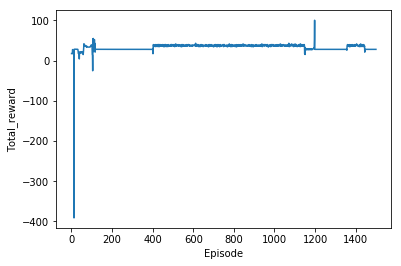

In [30]:
plt.xlabel('Episode')
plt.ylabel('Total_reward')

plt.plot(Episode,Total_reward) 

## 回顾

**问题 1**：请描述你在 `task.py` 中指定的任务。你如何设计奖励函数？

**回答**：任务为从（0,0,1）出发到达点（0,0,10）.奖励函数为1.-.03*(abs(self.sim.pose[:3] - self.target_pos)).sum()。如果到达指定高度，奖励加10.


**问题 2**：请简要描述你的智能体，你可以参考以下问题：

- 你尝试了哪些学习算法？哪个效果最好？
- 你最终选择了哪些超参数（比如 $\alpha$，$\gamma$，$\epsilon$ 等）？
- 你使用了什么样的神经网络结构（如果有的话）？请说明层数、大小和激活函数等信息。

**回答**：
使用了DDPG算法。
神经网络层数为2层，激活函数为‘relu’
超参数分别为：theta = 0.15，sigma = 0.1，gamma = 0.99，tau = 0.01


**问题 3**：根据你绘制的奖励图，描述智能体的学习状况。

- 学习该任务是简单还是困难？
- 该学习曲线中是否存在循序渐进或急速上升的部分？
- 该智能体的最终性能有多好？（比如最后十个阶段的平均奖励值）

**回答**：
该学习任务较简单。在曲线中除开始时无急速上升部分。最终奖励在27.8左右。


**问题 4**：请简要总结你的本次项目经历。你可以参考以下问题：

- 本次项目中最困难的部分是什么？（例如开始项目、运行 ROS、绘制、特定的任务等。）
- 关于四轴飞行器和你的智能体的行为，你是否有一些有趣的发现？

**回答**：
项目中最困难的部分是对飞行体的动作没有直观的感受，如果能规定动作再进行建模及算法训练效果会更好。
奖励函数的定义十分重要，在确定奖励合理之后一切做起来比较得心应手。
对于done的设计也较重要，防止智能体过度飞行超出范围报错。



### (可选)Plot Actor 及 Critic 结构
建议使用 ```from keras.utils import plot_model``` 来显示模型结构；